## Importação de dependências

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

## Coleta de dados

In [2]:
symbol = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-07-01'

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Open', 'Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close
Ticker,TSLA,TSLA
Date,,
2015-01-02,14.858000,14.620667
2015-01-05,14.303333,14.006000
2015-01-06,14.004000,14.085333
2015-01-07,14.223333,14.063333
2015-01-08,14.187333,14.041333


## Pré-processamento

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Função para criar janelas temporais
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1886, 30, 1)
(1886,)
(472, 30, 1)
(472,)


## Criação e treinamento do modelo

In [4]:
# Estrutura do modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=2)

Epoch 1/50


c:\Users\Lucas\Documents\GitHub\TechChallenge4\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 - 2s - 50ms/step - loss: 0.0131 - val_loss: 0.0016
Epoch 2/50
48/48 - 1s - 11ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/50
48/48 - 1s - 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/50
48/48 - 1s - 11ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/50
48/48 - 1s - 11ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/50
48/48 - 1s - 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/50
48/48 - 1s - 11ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 8/50
48/48 - 1s - 11ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/50
48/48 - 1s - 11ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/50
48/48 - 1s - 11ms/step - loss: 0.0016 - val_loss: 9.3782e-04
Epoch 11/50
48/48 - 1s - 11ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/50
48/48 - 1s - 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 13/50
48/48 - 1s - 11ms/step - loss: 0.0014 - val_loss: 8.6596e-04
Epoch 14/50
48/48 - 1s - 11ms/step - loss: 0.0014 - val_loss: 8.6763e-04
Epoch 15/50
48/48 - 1s - 11ms/step - loss:

## Resultados

In [5]:
# Avaliação
y_pred = model.predict(X_test, verbose=0)
y_test_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

loss = model.evaluate(X_test, y_test, verbose=0)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(root_mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'Loss: {loss}')
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

Loss: 0.0005120356217958033
Mean Absolute Error (MAE): 4.87
Root Mean Squared Error (RMSE): 3.01
Mean Absolute Percentage Error (MAPE): 0.05


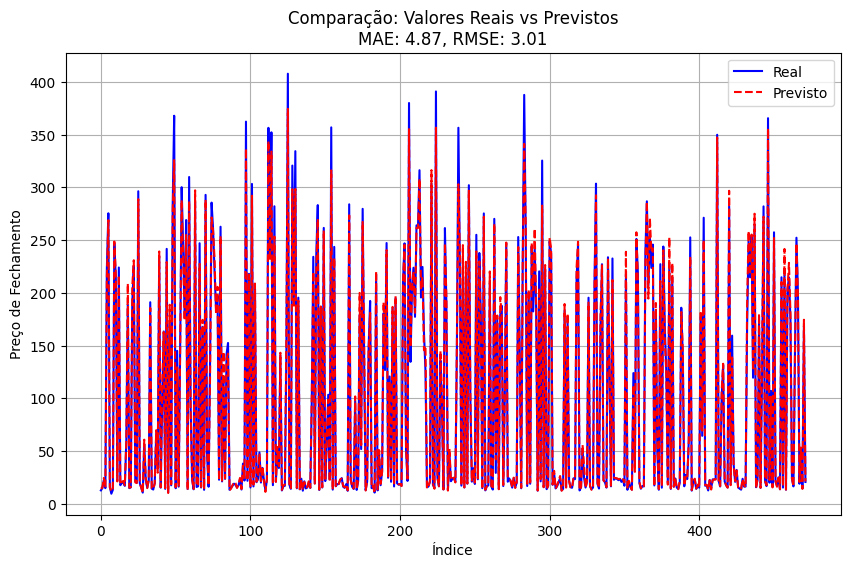

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Real", color='blue')
plt.plot(y_pred_rescaled, label="Previsto", color='red', linestyle='dashed')
plt.title(f'Comparação: Valores Reais vs Previstos\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

## Serialização e armazenamento dos artefatos do modelo e do scaler

In [7]:
model.save(f".\\Models\\model_{symbol}.keras")
joblib.dump(scaler, f'.\\Models\\scaler_{symbol}.pkl')

['.\\Models\\scaler_TSLA.pkl']